# Building A Variational Autoencoder
input -> encoder -> z_log_var, z_mean -> sample -> decoder -> output

In [6]:
# imports
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Pad(2, 0.0)])
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

Sneaker  Trouser  Pullover  Ankle Boot


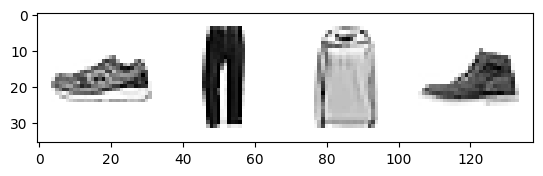

In [8]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

### build the sampling layer

In [9]:
class Sampling(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        z_mean, z_log_var = x
        z_sigma = torch.exp(0.5 * z_log_var)
        epsilon = torch.normal(torch.zeros(z_mean.size()), 1)
        return z_mean + z_sigma * epsilon

### build ~variational~ autoencoder

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder_convs = nn.Sequential(
            # 32x32 in, 16x16 out
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # 16x16 in, 8x8 out
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # 8x8 in, 4x4 out
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # shape before flattening is [128, 4, 4]
            nn.Flatten(),
        )  
        self.encoder_mean = nn.Linear(128 * 4 * 4, 2)
        self.encoder_log_var = nn.Linear(128 * 4 * 4, 2)
        self.encoder_sampling = Sampling()
        
        shape_before_flattening = (128, 4, 4)
        self.decoder = nn.Sequential(
            nn.Linear(2, np.prod(shape_before_flattening)),
            nn.Unflatten(1, shape_before_flattening),
            # 4x4 -> 8x8
            nn.ConvTranspose2d(128, 128, stride=2, kernel_size=3, padding=1, output_padding=1),
            nn.ReLU(),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(128, 64, stride=2, kernel_size=3, padding=1, output_padding=1),
            nn.ReLU(),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1, output_padding=1),
            nn.ReLU(),
            # reduce output dims to 1
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid(),  # to map between 0 & 1
        )

    def forward(self, x):
        x = self.encoder_convs(x)
        z_mean = self.encoder_mean(x)
        z_log_var = self.encoder_log_var(x)
        encoded = self.encoder_sampling([z_mean, z_log_var])

        # measure divergence of encoding from N(0,1)
        self.kl = -0.5 * torch.sum(1 + z_log_var - z_mean ** 2 - torch.exp(z_log_var))
            
        decoded = self.decoder(encoded)
        return decoded
    '''
    test = encoded
    for m in self.decoder.children():
            test = m(test)
            print(test.shape)
    '''

## train the model
Note that we will be adding a 
[Kullback–Leibler divergence](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8) 
term to the loss, which measures the difference between two probablility distributions.
Specifically, we'll be measuring the difference between the distribution that our encoder outputs
and the standard normal (the equation for `self.kl` above is shown 
[here](https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/) ).

### KL collapse
Also note that in our training we weight our kl_loss by 0.001 to prevent it from dominating our model; if we over weight the KL loss, the model may initially go for the easy optimization route of matching the 
standard normal first and we end up in a situation where the encoder just outputs N(0, 1) and the decoder ends 
up guessing an average that minimizes loss for the image set since it has no useful input:

<img src="kl_collapse.png" alt="image" width="500" height="auto">

In [46]:
model = VAE()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
batch_size = 100
# Reinit data loaders for our datasets
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [47]:
for epoch in range(epochs):
    batch_num = 0

    train_loss = 0
    model.train()
    for (img, _) in training_loader:
        recovered = model(img)

        loss = loss_fn(recovered, img)
        kl_loss = model.kl / batch_size
        loss = kl_loss * 0.001 + loss
        train_loss += loss.item()

        optimizer.zero_grad() # reset gradients
        loss.backward()
        optimizer.step()
        if batch_num % 10 == 0:
            print(f"\rBatch {batch_num}, kl_loss {kl_loss:.4f}, loss {loss:.4f}", end='')
        batch_num += 1
    train_loss /= len(training_loader.dataset)

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for img, _ in validation_loader:
            output = model(img)
            loss = loss_fn(output, img)
            val_loss += loss.item()
    val_loss /= len(validation_loader.dataset)

    print(f'\nEpoch:{epoch}, Train Loss:{train_loss:.4f}, Val Loss:{val_loss:.4f}')

Batch 590, kl_loss 5.7058, loss 0.2720
Epoch:0, Train Loss:0.0029, Val Loss:0.0026
Batch 590, kl_loss 5.9370, loss 0.2617
Epoch:1, Train Loss:0.0026, Val Loss:0.0026
Batch 590, kl_loss 5.9519, loss 0.2415
Epoch:2, Train Loss:0.0026, Val Loss:0.0025
Batch 590, kl_loss 6.0089, loss 0.2563
Epoch:3, Train Loss:0.0026, Val Loss:0.0025
Batch 590, kl_loss 6.1756, loss 0.2684
Epoch:4, Train Loss:0.0026, Val Loss:0.0025


In [48]:
save_path = "basic_vae"
torch.save(model.state_dict(), save_path)

In [ ]:
# load model
checkpoint = torch.load("basic_vae")
model.load_state_dict(checkpoint)

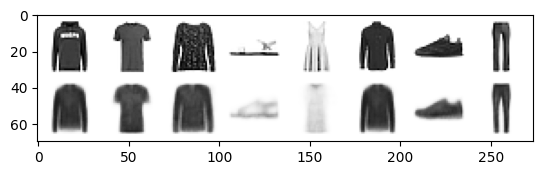

In [49]:
# apply model
model.eval()
# original
im_batch, label_batch = next(iter(validation_loader))
# encode/decode
im_recovered = model(im_batch)

# view images
start_idx = 87
how_many = 8
imgs = torch.cat((im_batch[start_idx:start_idx+how_many], 
                  im_recovered[start_idx:start_idx+how_many]))
img_grid = torchvision.utils.make_grid(
    imgs,
    nrow=how_many)
matplotlib_imshow(img_grid, one_channel=True)

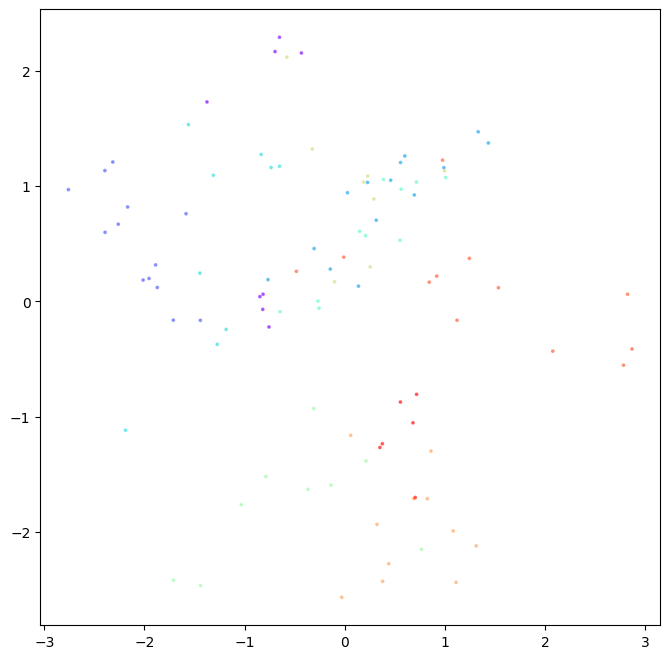

In [57]:
embeddings = model.encoder_mean(model.encoder_convs(im_batch)).detach().numpy()
em_labels = label_batch
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], 
            embeddings[:, 1],
            cmap="rainbow",
            c=label_batch, alpha=0.5, s=3)
plt.show()